In [1]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

In [8]:
import numpy as np
# import torch, torchvision
# from torchvision import transforms as tr
# from torch import nn
# from torch.nn import functional as F
import os
# import random
# import time
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

import json
# import transformers


In [9]:
result_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/jun15/'

In [10]:
def proc_fp(fp):
    with open(fp, "r") as json_file:
        data = json.load(json_file)
    return data

In [11]:
# all_mean = []
# all_std = []
# for stage in range(1,2):
#     result_dir = result_root+'s'+str(stage)+'/gradients/'
#     result_files = [result_dir+item
#                for item in os.listdir(result_dir)]
#     for fp in result_files:
#         json_data = proc_fp(fp)
#         if fp.split('/')[-1].split('_')[0]=='gradmean':
#             all_mean.append(json_data)
#         if fp.split('/')[-1].split('_')[0]=='gradstd':
#             all_std.append(json_data)

In [12]:
def get_tag(fp):
    # g0g1g2, g2g1g0, g3g1g2, grgrgr, g2g2g2
    # g0, g2, g3, gr
    # g0g1, g2g1, g2g2, grgr, g3g1
    stem = Path(fp).stem
    parts = stem.split('_')
    glast = parts[1]
    
    if 'pre' in stem:
        gpre = parts[-1]
        gpre = gpre.replace('pre.', '')
        
        full_tag = gpre+glast
    else:
        full_tag = glast
        
    return full_tag


def get_group(fp):
    parts = Path(fp).stem.split('_')
    glast = parts[1]
    return glast

def get_meanOrstd(fp):
    parts = Path(fp).stem.split('_')
    return parts[0]

def get_seed(fp):
    parts = Path(fp).stem.split('_')
    return parts[3]
def get_curr(fp):
    parts = Path(fp).stem.split('_')
    return parts[4]

def get_condition(fp):
    parts = Path(fp).stem.split('_')
    return parts[5]


tagname_dict = {
    'g0':'g0 any', 
    'g0g1': 'g0g1g2', 
    'g0g1g2': 'g0g1g2',
    'g2':'g2 any', 
    'g2g1': 'g2g1g0', 
    'g2g1g0': 'g2g1g0',
    'g2g2': 'g2g2g2',
    'g2g2g2':'g2g2g2',
    'g0g0': 'g0g0g0', 
    'g0g0g0':'g0g0g0'}

In [13]:
a,b,*c=[1,2,3,4]

In [14]:
c

[3, 4]

In [15]:
def proc_stage(stage, result_root):
    all_mean = {}
    all_std = {}
    all_snr = {}
    result_dir = result_root+'s'+str(stage)+'/gradients/'
    result_files = [result_dir+item
                    for item in os.listdir(result_dir)
                   if Path(result_dir+item).suffix=='.json']
    for fp in result_files:
#         print(fp)
#         break
        parts = Path(fp).stem.split('_')
        prefix, glast, _, seed, curr, *plast = parts
        tag = get_tag(fp)
#         curr = get_curr(fp)
#         seed= get_seed(fp)
        cond = plast[0]
#         other_id = get_other_id(fp)
        data_id = '_'.join([curr, seed, cond])#'_'.join([curr,seed, other_id])
# #         print(curr)
    #     if gr=='g0':
        json_data = proc_fp(fp)
        prefix = get_meanOrstd(fp)
        if prefix=='gradmean':
            all_mean[data_id]=json_data
        elif prefix=='gradstd':
            all_std[data_id]=json_data
        elif prefix=='gradsnr':
            all_snr[data_id]=json_data
    return all_mean, all_std, all_snr

In [16]:
all_mean, all_std, all_snr ={},{},{}
for stage in range(1,4):
    sx_mean, sx_std, sx_snr = proc_stage(stage, result_root)
    all_mean[stage]=deepcopy(sx_mean)
    all_std[stage]=deepcopy(sx_std)
    all_snr[stage]=deepcopy(sx_snr)

In [17]:
pgr_names = ['pgr1', 'pgr12', 'pgr183', 'pgr246'] #list(all_mean[1].keys())[1:]

In [18]:
avail_keys = list(all_mean[1].keys())
print(avail_keys)

['dev_152_longshuffle', 'adev_152_static', 'adev_151_static', 'dev_151_longshuffle', 'dev_151_default', 'adev_151_default', 'adev_152_default']


In [19]:
# bin_edges = np.logspace(start=-5, stop=0, num=101)

pgrname2layer = {'pgr1': 'Token Projection',
                 'pgr12': 'Encoder L1',
                 'pgr183': 'Encoder',
                 'pgr246': 'Decoder'}

In [20]:
def get_colors(n_clr):
# Choose a sequential colormap
    colormap = plt.cm.viridis
    colors = [colormap(i/n_clr) for i in range(n_clr)]
    return colors

In [21]:
key = avail_keys[0]
stage=1
pgr_name = 'pgr246'
np.asarray(all_mean[stage][key][pgr_name]).shape

(50, 1)

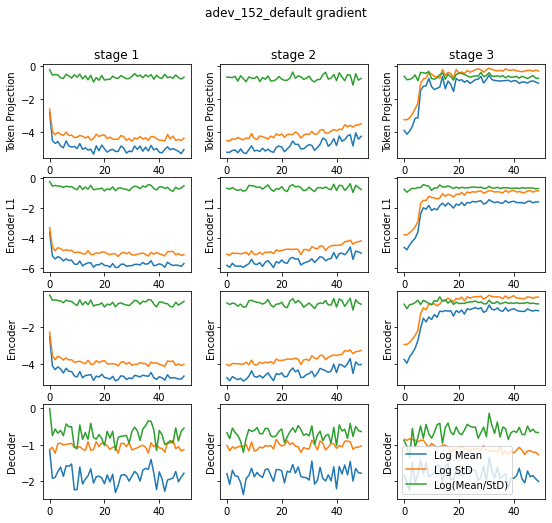

In [23]:
key = avail_keys[-1]
cvar = all_mean

nrow=len(pgr_names)
ncol=3

fig,ax = plt.subplots(nrow,ncol, figsize=(ncol*3,nrow*2), sharey='row')


for i_col in range(0,ncol):   
    stage = i_col+1
    for i_row in range(nrow):
        cax = ax[i_row,i_col]
        pgr_name = pgr_names[i_row]
        
        iters = all_mean[stage][key]['iter']
        colors = get_colors(len(iters))
        
        mean_data = np.asarray(all_mean[stage][key][pgr_name])
        std_data = np.asarray(all_std[stage][key][pgr_name])
        snr_data = np.asarray(all_snr[stage][key][pgr_name])
        
#         medians = [proc_hist(iter_hist, bin_edges) 
#                    for iter_hist in cdata]
        cax.plot(mean_data, label='Log Mean')
        cax.plot(std_data, label='Log StD')
        cax.plot(snr_data, label='Log(Mean/StD)')
        
#         for i_iter in range(len(iters)):
#             cdata = cvar[stage][key][pgr_name][i_iter]
#             cax.plot(bin_edges[:-1], cdata,  
#                        color=colors[i_iter], alpha=0.9, label=f'Iteration {iters[i_iter]}')

#             cdata = all_std[0][pgr_name][i_iter]
#             cax[1].plot(bin_edges[:-1], cdata,  
#                        color=colors[i_iter], alpha=0.9, label=f'Iteration {iters[i_iter]}')
        if i_row==0:
            cax.set_title('stage '+str(stage))
#         cax.set_xscale('log')
        cax.set_ylabel(pgrname2layer[pgr_name])

fig.suptitle(key+' gradient')#_mean')

# ax[0,0].legend()
ax[-1,-1].legend()
# ax[0,1].set_title('gradient mean')
# ax[0,1].set_title('gradient std')

Text(0.5, 0.98, '141_dev_gradient_mean')

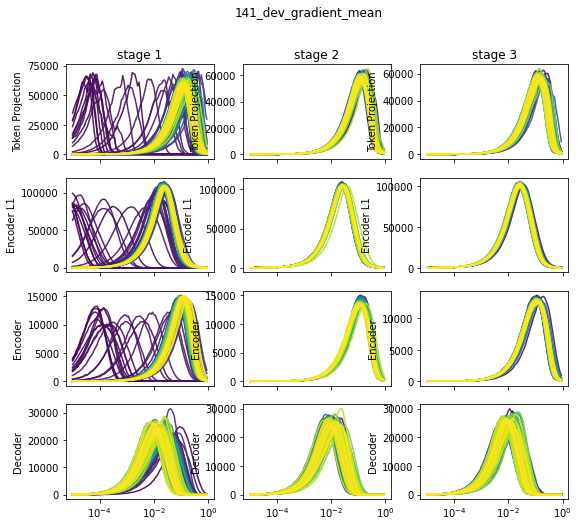

In [18]:
key = avail_keys[1]
cvar = all_mean

nrow=len(pgr_names)
ncol=3

fig,ax = plt.subplots(nrow,ncol, figsize=(ncol*3,nrow*2), sharex=True)


for i_col in range(ncol):   
    stage = i_col+1
    for i_row in range(nrow):
        cax = ax[i_row,i_col]
        pgr_name = pgr_names[i_row]
        
        iters = all_mean[stage][key]['iter']
        colors = get_colors(len(iters))
        for i_iter in range(len(iters)):
            cdata = cvar[stage][key][pgr_name][i_iter]
            cax.plot(bin_edges[:-1], cdata,  
                       color=colors[i_iter], alpha=0.9, label=f'Iteration {iters[i_iter]}')

#             cdata = all_std[0][pgr_name][i_iter]
#             cax[1].plot(bin_edges[:-1], cdata,  
#                        color=colors[i_iter], alpha=0.9, label=f'Iteration {iters[i_iter]}')
        if i_row==0:
            cax.set_title('stage '+str(stage))
        cax.set_xscale('log')
        cax.set_ylabel(pgrname2layer[pgr_name])

fig.suptitle(key+'_gradient_mean')
    
# ax[-1,-1].legend()
# ax[0,1].set_title('gradient mean')
# ax[0,1].set_title('gradient std')

In [37]:
def proc_hist(frequencies, bin_edges):
    cumulative_sum = np.cumsum(frequencies)
    total_observations = np.sum(frequencies)
    median_index = np.argwhere(cumulative_sum >= total_observations / 2)[0][0]

    lower_edge = bin_edges[median_index]
    upper_edge = bin_edges[median_index + 1]
    
    return lower_edge
    
# len(cvar[stage][key][pgr_name][0])

Text(0.5, 0.98, '141_dev_gradient_mean')

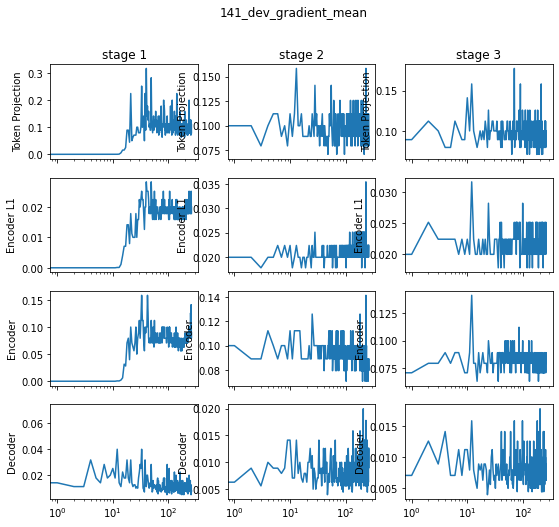

In [40]:
key = avail_keys[1]
cvar = all_mean

nrow=len(pgr_names)
ncol=3

fig,ax = plt.subplots(nrow,ncol, figsize=(ncol*3,nrow*2), sharex=True)


for i_col in range(ncol):   
    stage = i_col+1
    for i_row in range(nrow):
        cax = ax[i_row,i_col]
        pgr_name = pgr_names[i_row]
        
        iters = all_mean[stage][key]['iter']
        colors = get_colors(len(iters))
        
        cdata = cvar[stage][key][pgr_name]
        
        medians = [proc_hist(iter_hist, bin_edges) 
                   for iter_hist in cdata]
        cax.plot(medians)
        
#         for i_iter in range(len(iters)):
#             cdata = cvar[stage][key][pgr_name][i_iter]
#             cax.plot(bin_edges[:-1], cdata,  
#                        color=colors[i_iter], alpha=0.9, label=f'Iteration {iters[i_iter]}')

#             cdata = all_std[0][pgr_name][i_iter]
#             cax[1].plot(bin_edges[:-1], cdata,  
#                        color=colors[i_iter], alpha=0.9, label=f'Iteration {iters[i_iter]}')
        if i_row==0:
            cax.set_title('stage '+str(stage))
        cax.set_xscale('log')
        cax.set_ylabel(pgrname2layer[pgr_name])

fig.suptitle(key+'_gradient_mean')
    
# ax[-1,-1].legend()
# ax[0,1].set_title('gradient mean')
# ax[0,1].set_title('gradient std')

Text(0.5, 0.98, '141_yo_gradient_mean')

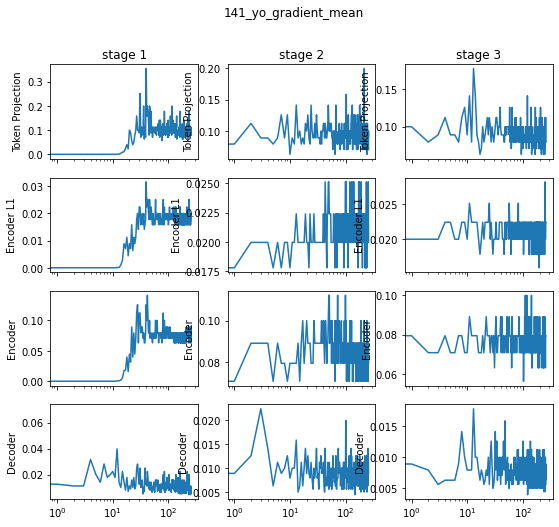

In [39]:
key = avail_keys[2]
cvar = all_mean

nrow=len(pgr_names)
ncol=3

fig,ax = plt.subplots(nrow,ncol, figsize=(ncol*3,nrow*2), sharex=True)


for i_col in range(ncol):   
    stage = i_col+1
    for i_row in range(nrow):
        cax = ax[i_row,i_col]
        pgr_name = pgr_names[i_row]
        
        iters = all_mean[stage][key]['iter']
        colors = get_colors(len(iters))
        
        cdata = cvar[stage][key][pgr_name]
        
        medians = [proc_hist(iter_hist, bin_edges) 
                   for iter_hist in cdata]
        cax.plot(medians)
        
#         for i_iter in range(len(iters)):
#             cdata = cvar[stage][key][pgr_name][i_iter]
#             cax.plot(bin_edges[:-1], cdata,  
#                        color=colors[i_iter], alpha=0.9, label=f'Iteration {iters[i_iter]}')

#             cdata = all_std[0][pgr_name][i_iter]
#             cax[1].plot(bin_edges[:-1], cdata,  
#                        color=colors[i_iter], alpha=0.9, label=f'Iteration {iters[i_iter]}')
        if i_row==0:
            cax.set_title('stage '+str(stage))
        cax.set_xscale('log')
        cax.set_ylabel(pgrname2layer[pgr_name])

fig.suptitle(key+'_gradient_mean')
    
# ax[-1,-1].legend()
# ax[0,1].set_title('gradient mean')
# ax[0,1].set_title('gradient std')

Text(0.5, 0.98, '923_yo_gradient_std')

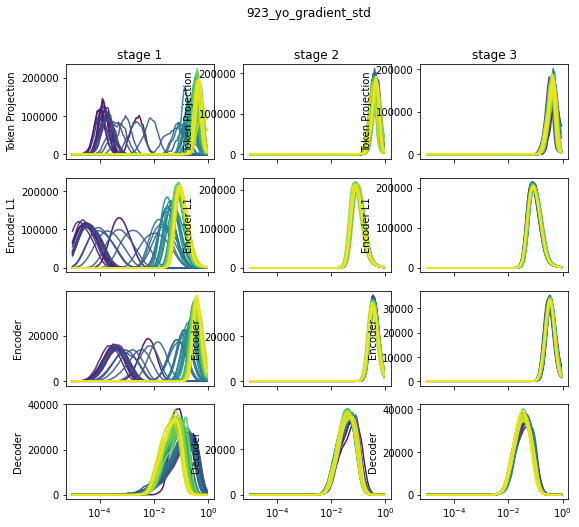

In [61]:
key = avail_keys[5]
cvar = all_std

nrow=len(pgr_names)
ncol=3

fig,ax = plt.subplots(nrow,ncol, figsize=(ncol*3,nrow*2), sharex=True)


for i_col in range(ncol):   
    stage = i_col+1
    for i_row in range(nrow):
        cax = ax[i_row,i_col]
        pgr_name = pgr_names[i_row]
        
        iters = all_mean[stage][key]['iter']
        colors = get_colors(len(iters))
        for i_iter in range(len(iters)):
            cdata = cvar[stage][key][pgr_name][i_iter]
            cax.plot(bin_edges[:-1], cdata,  
                       color=colors[i_iter], alpha=0.9, label=f'Iteration {iters[i_iter]}')

#             cdata = all_std[0][pgr_name][i_iter]
#             cax[1].plot(bin_edges[:-1], cdata,  
#                        color=colors[i_iter], alpha=0.9, label=f'Iteration {iters[i_iter]}')
        if i_row==0:
            cax.set_title('stage '+str(stage))
        cax.set_xscale('log')
        cax.set_ylabel(pgrname2layer[pgr_name])

fig.suptitle(key+'_gradient_std')
    
# ax[-1,-1].legend()
# ax[0,1].set_title('gradient mean')
# ax[0,1].set_title('gradient std')

In [29]:
bin_edges = np.array([0, 1, 2, 3, 4, 5])  # Example bin edges
frequencies = np.array([10, 15, 20, 30, 25])  # Example frequencies

cumulative_sum = np.cumsum(frequencies)
total_observations = np.sum(frequencies)
median_index = np.argwhere(cumulative_sum >= total_observations / 2)[0][0]

lower_edge = bin_edges[median_index]
upper_edge = bin_edges[median_index + 1]



print("Lower edge:", lower_edge)
print("Upper edge:", upper_edge)

Lower edge: 3
Upper edge: 4


In [24]:
(cumulative_sum >= total_observations / 2)

array([False, False, False,  True,  True])

In [28]:
np.argwhere(cumulative_sum >= total_observations / 2)[0][0]

3

In [42]:
flattened_arr = np.random.rand(10)
xtt = np.asarray([np.median(flattened_arr)])

In [44]:
np.argmax(xtt)

0